# Оценка длительностей и количества раундов инвентаризации

В этом эксперименте найдем оценки длительностей раундов инвентаризации и их 
числа за время нахождения метки в области действия счиытвателя.

## Настройка ноутбука

In [35]:
# Если что-то меняется в коде, мы хотим это сразу видеть здесь
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib
import matplotlib.pyplot as plt

from itertools import product
import numpy as np
import pandas as pd

# Подключаем локальные пакеты
from pysim.models.monte_carlo.protocol import TagFrame, ReaderFrame, TagEncoding, \
    Sel, DR, Session, Bank, InventoryFlag as Flag, \
    Query, QueryRep, Ack, ReqRn, Read, \
    Rn16Reply, AckReply, ReqRnReply, ReadReply, max_t1, max_t2

from utility.jupyter_helpers import setup_matplotlib, get_color, savefig, \
    set_axes_formatter

In [8]:
# Настраиваем matplotlib
%matplotlib inline
setup_matplotlib()

Введем вспомогательные функции для конвертации единиц.

In [9]:
def kmph2mps(x: float) -> float:
    """Перевести км/ч в м/с"""
    return x * 5 / 18


def str_dr(dr: DR) -> str:
    return "64/3" if dr == DR.DR_643 else "8"


def random_hex_string(bs: int) -> str:
    return "".join([f"{np.random.randint(0, 256):02X}" for _ in range(bs)])

## Параметры окружения

Зададим общие параметры, которые будут использоваться в расчетах по-умолчанию.

In [23]:
TARI_US = [6.25, 12.5, 18.75, 25]
M = [TagEncoding.FM0, TagEncoding.M2, TagEncoding.M4, TagEncoding.M8]
DRS = [DR.DR_8, DR.DR_643]
L = 5             # длина области, где есть связь между считывателем и меткой
V = 60            # скорость автомобиля, км/ч
Q = 4             # по-умолчанию, будем исходить из этого значения параметра Q
RTCAL_MUL = 2.75  # во сколько раз RTcal больше Tari
TRCAL_MUL = 1.95  # во сколько раз TRcal больше RTcal
EPC_SIZE = 12     # длина EPCID в байтах
TID_SIZE = 8      # длина TID в байтах

EPC = random_hex_string(EPC_SIZE)
TID = random_hex_string(TID_SIZE)

print("I will use these constants:")
print(f"- EPC: {EPC} ({EPC_SIZE} bytes)")
print(f"- TID: {TID} ({TID_SIZE} bytes)")

I will use these constants:
- EPC: AAE48AEB5D638D51BC47FFFE (12 bytes)
- TID: 188874B9AE7B216C (8 bytes)


## Расчет длительностей команд и ответов

Для начала определим, как будут меняться длительность команд считывателя и ответов метки в зависимости от настроек протокола.

Будем рассматривать длительности сообщений:

- команд `Query`, `QueryRep`, `Ack`, `Req_RN`, `Read`
- ответов `RN16`, `EPC+PC+CRC`, `Handle`, `Data`

Зависимости будем проверять от:

- `DR` (и команды, и ответы)
- `Tari` (и команды, и ответы)
- `TRExt` (ответы)
- `M` (ответы)

Длительности символов `data-1`, `RTcal` и `TRcal` определяются через множители 
`Tari`. Согласно стандарту (c. 29):

- `2.5 Tari <= RTcal <= 3.0 Tari`
- `1.1 RTcal <= TRcal <= 3.0 RTcal`

При расчете будем ориентироваться на средние значения коэффициентов, то есть 
будем полагать, что:

- `RTcal = 2.75 Tari`
- `TRcal = 1.95 RTcal`

Длительность `RTcal` равна суммарной длительности `data-0 = Tari` и `data-1`.

Кроме длительностей команд и ответов вычислим величину `BLF = DR / TRcal` и 
скорость в канале от метки к считывателю, равную `BLF / M`.

> Для удобства, все длительности будем хранить в **микросекундах**, BLF - 
в **КГц**, а bitrate - в **кбит/c**.

In [24]:
def build_messages_df() -> pd.DataFrame:
    """
    Построить DataFrame для всевозможных настроек канала и рассчитанными 
    длительностями команд и ответов.
    
    В датафрейме используются следующие единицы измерений:
    
    - для длительностей: микросекунды (мкс)
    - для частот: килогерцы (КГц)
    - для скоростей: килобиты в секунду (кбит/с)
    
    Returns:
        df (DataFrame)
    """
    rows = []
    for tari_us, m, dr, trext in product(TARI_US, M, DRS, (False, True)):
        tari = tari_us * 1e-6
        rtcal = RTCAL_MUL * tari
        trcal = TRCAL_MUL * rtcal
        blf = dr.ratio / trcal
        bitrate = blf / m.value
        
        # Строим команды
        # --------------
        preamble = ReaderFrame.Preamble(tari, rtcal, trcal)
        sync = ReaderFrame.Sync(tari, rtcal)
        
        query = Query(dr=dr, m=m, trext=trext, sel=Sel.SL_ALL, 
                           session=Session.S0, target=Flag.A, 
                           q=4, crc5=0x15)
        query_rep = QueryRep(session=Session.S0)
        ack = Ack(0x5555)
        req_rn = ReqRn(0x5555, 0x5555)
        read = Read(Bank.TID, 0, 4, rn=0x5555, crc16=0x5555)
        
        # Строим ответы
        # -------------
        rn16 = Rn16Reply(0x5555)
        epc_pc = AckReply(EPC)
        handle = ReqRnReply(0)
        data = ReadReply([0xABAB] * (TID_SIZE//2), 0, 0)
        
        rows.append({
            'Tari': tari_us,     
            'RTcal': rtcal * 1_000_000,
            'TRcal': trcal * 1_000_000,
            'M': m,
            'DR': dr,
            'BLF': blf / 1_000,
            'TRext': trext,
            'Bitrate': bitrate / 1_000,
            'Query': ReaderFrame(preamble, query).duration * 1_000_000,
            'QueryRep': ReaderFrame(sync, query_rep).duration * 1_000_000,
            'Ack': ReaderFrame(sync, ack).duration * 1_000_000,
            'Req_RN': ReaderFrame(sync, req_rn).duration * 1_000_000,
            'Read': ReaderFrame(sync, read).duration * 1_000_000,
            'RN16': TagFrame(m, trext, blf, rn16).duration * 1_000_000,
            'EPC+PC+CRC': TagFrame(m, trext, blf, epc_pc).duration * 1_000_000,
            'Handle': TagFrame(m, trext, blf, handle).duration * 1_000_000,
            'Data': TagFrame(m, trext, blf, data).duration * 1_000_000,
        })
    df = pd.DataFrame(rows)
    return df

DF = build_messages_df()
DF

,Tari,RTcal,TRcal,M,DR,BLF,TRext,Bitrate,Query,QueryRep,Ack,Req_RN,Read,RN16,EPC+PC+CRC,Handle,Data
0,6.25,17.1875,33.515625,TagEncoding.FM0,DR.DR_8,636.519037,False,636.519037,230.390625,60.9375,190.625,375.0,496.875,42.418213,218.375244,67.554932,169.672852
1,6.25,17.1875,33.515625,TagEncoding.FM0,DR.DR_8,636.519037,True,636.519037,235.078125,60.9375,190.625,375.0,496.875,61.270752,237.227783,86.407471,188.525391
2,6.25,17.1875,33.515625,TagEncoding.FM0,DR.DR_643,636.519037,False,636.519037,235.078125,60.9375,190.625,375.0,496.875,42.418213,218.375244,67.554932,169.672852
3,6.25,17.1875,33.515625,TagEncoding.FM0,DR.DR_643,636.519037,True,636.519037,239.765625,60.9375,190.625,375.0,496.875,61.270752,237.227783,86.407471,188.525391
4,6.25,17.1875,33.515625,TagEncoding.M2,DR.DR_8,636.519037,False,318.259518,235.078125,60.9375,190.625,375.0,496.875,84.836426,436.750488,135.109863,339.345703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,25.00,68.7500,134.062500,TagEncoding.M4,DR.DR_643,159.129759,True,39.782440,940.312500,206.2500,725.000,1462.5,1950.000,980.332031,3795.644531,1382.519531,3016.406250
60,25.00,68.7500,134.062500,TagEncoding.M8,DR.DR_8,159.129759,False,19.891220,921.562500,206.2500,725.000,1462.5,1950.000,1357.382812,6988.007812,2161.757812,5429.531250
61,25.00,68.7500,134.062500,TagEncoding.M8,DR.DR_8,159.129759,True,19.891220,940.312500,206.2500,725.000,1462.5,1950.000,1960.664062,7591.289062,2765.039062,6032.812500
62,25.00,68.7500,134.062500,TagEncoding.M8,DR.DR_643,159.129759,False,19.891220,940.312500,206.2500,725.000,1462.5,1950.000,1357.382812,6988.007812,2161.757812,5429.531250


Посмотрим на общий разброс длительностей отдельных команд и ответов.

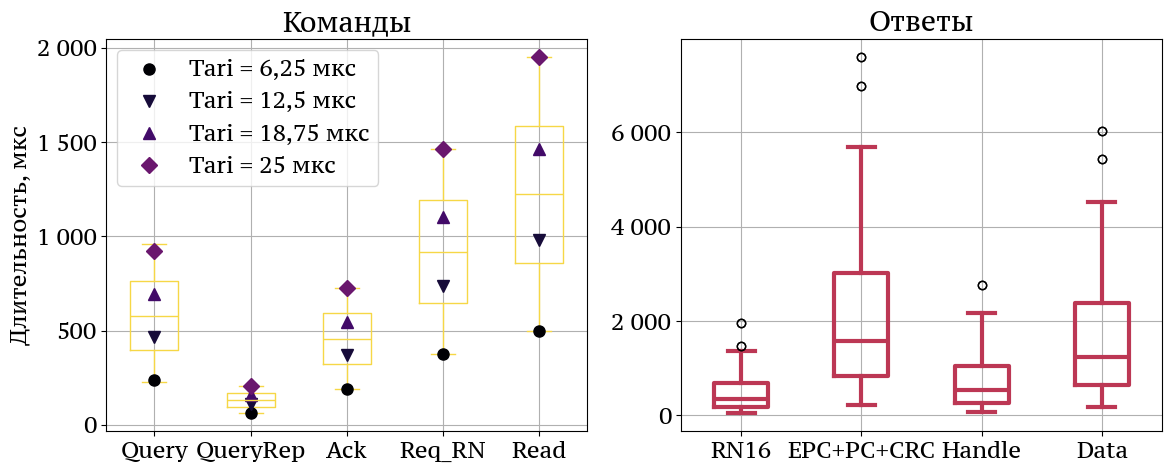

In [25]:
def plot_boxes_for_all_messages(image_name: str = ""):
    fig, (ax0, ax1) = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
    
    props_0 = {'linewidth': 1, 'color': get_color(0.9)}
    props_1 = {'linewidth': 3, 'color': get_color(0.5)}
    
    COMMANDS = ['Query', 'QueryRep', 'Ack', 'Req_RN', 'Read']
    RESPONSES = ['RN16', 'EPC+PC+CRC', 'Handle', 'Data']
    
    DF.boxplot(COMMANDS, ax=ax0, 
               boxprops=props_0, whiskerprops=props_0, capprops=props_0, 
               meanprops=props_0, medianprops=props_0, 
               positions=range(len(COMMANDS)))

    DF.boxplot(RESPONSES, ax=ax1, 
               boxprops=props_1, whiskerprops=props_1, capprops=props_1, 
               meanprops=props_1, medianprops=props_1)
    
    df = (DF[[*COMMANDS, "Tari"]]
          .groupby("Tari", as_index=False)
          .mean()
          .melt(id_vars=['Tari'], var_name="CMD", value_name="Duration"))
    
    markers = ["o", "v", "^", "D"]
    
    for i, tari in enumerate(TARI_US):
        df1 = df[df.Tari == tari]
        ax0.plot(range(len(COMMANDS)), df1["Duration"], 
                 color=get_color(i/10), linestyle='', marker=markers[i],
                 markersize=8, label=f"Tari = {tari:n} мкс")
    
    set_axes_formatter(ax0, ax1, use_y=True)
    ax0.legend()
    ax0.set_ylabel("Длительность, мкс")
    ax0.set_title("Команды")
    ax1.set_title("Ответы")

    plt.tight_layout()
    # savefig(image_name)

plot_boxes_for_all_messages("ch2_messages_durations")

Можно заметить, что разброс длительностей команд и ответов очень большой. Длительности команд могут различаться в 3-5 раз, а длительности ответов - в 10 и больше раз.


Рассмотрим внимательнее, как зависят длительности ответов от тех или иных параметров.

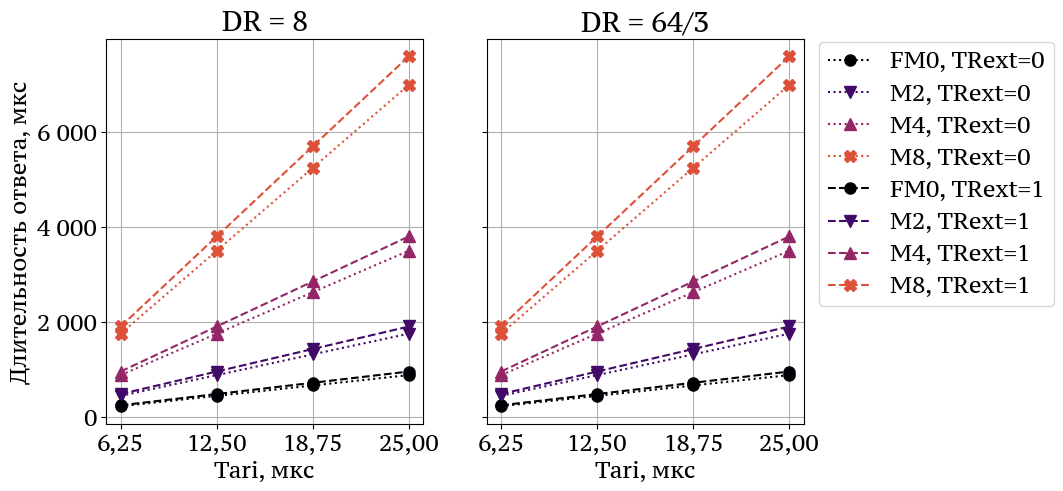

In [27]:
def plot_t2r_props(image_name: str = ""):
    fig, (ax0, ax1) = plt.subplots(figsize=(9, 5), ncols=2, sharey=True)
    
    markers = ["o", "v", "^", "X"]
    linestyles = [':', '--']
    
    for i, trext in enumerate([False, True]):
        df = DF[DF.TRext == trext][["Tari", "M", "DR", "EPC+PC+CRC", "BLF"]]
        df0 = df[df.DR == DR.DR_8]
        df1 = df[df.DR == DR.DR_643]
        ls = linestyles[i]

        for j, m in enumerate(M):
            
            y0 = [df0[(df0.Tari == t) & (df0.M == m)]['EPC+PC+CRC'] 
                  for t in TARI_US]
            
            y1 = [df1[(df1.Tari == t) & (df1.M == m)]['EPC+PC+CRC'] 
                  for t in TARI_US]
            
            c = get_color(j / len(M) * 0.8)
            marker = markers[j]
            
            label = f"{m.name}, TRext={1 if trext else 0}"
            ax0.plot(TARI_US, y0, linestyle=ls, color=c, 
                     marker=marker, markersize=8, label=label)
            ax1.plot(TARI_US, y1, linestyle=ls, color=c, 
                     marker=marker, markersize=8, label=label)
    
    for ax in (ax0, ax1):
        ax.set_xticks(TARI_US)
        ax.set_xlabel("Tari, мкс")
        ax.grid()
    
    ax0.set_ylabel("Длительность ответа, мкс") 
    ax0.set_title("DR = 8")
    ax1.set_title("DR = 64/3")
        
    set_axes_formatter(ax0, ax1, use_y=True)
    handles, labels = ax0.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', 
               bbox_to_anchor=(1.19, 0.61), ncol=1)
    # savefig(image_name)

plot_t2r_props("ch2_response_durations")

## Вычисление длительности раунда с одной меткой

В следующих расчетах будем исходить из предположения, что в раунде участвует одна метка.
В общем случае это предположение, конечно, не выполняется, но для системы идентификации
автомобилей оно имеет смысл - из-за геометрии автомобилей и малой длины области чтения
вероятность попадания двух и более меток в зону действия считывателя одновременно мала.

Максимальную длительность раунда будем вычислять по формуле:

$$
\overline{T}_R = t_s + (2^Q - 1) t_e,
$$
где $t_e = T_{\text{QueryRep}} + T_1 + T_3$ - длительность пустого слота, а $t_s$ -
длительность слота с ответом. Если требуется идентифицировать метку только по EPCID,
то $t_s = t_s^{\text{epc}}$:

$$
t_s^{\text{epc}} = T_{\text{Query}} + T_1 + T_{\text{RN16}} + T_2 + 
T_{\text{ACK}} + T_1 + T_{\text{EPCID}} + T_2.
$$

Если же для идентификации используется TID, то $t_s = t_s^{\text{tid}}$:

$$
t_s^{\text{tid}} = t_s^{\text{epc}} + T_{\text{Req_RN}} + T_1 + 
T_{\text{Handle}} + T_2 + T_{\text{Read}} + T_1 + T_{\text{Data}} + T_2.
$$

В действительности длительность раунда вычисляется гораздо сложнее. Если в раунде 
участвуют несколько меток, то будет больше слотов с успешными передачами, а также могут
появиться слоты с коллизиями. Кроме того, из-за BER слоты с ответами меток без коллизий
могут иметь меньшую длительность, если какой-то из ответов не будет доставлен.

> Подробнее зависимости длительностей раундов анализируются в главе, посвященной 
> аналитической модели системы радиочастотной идентификации.

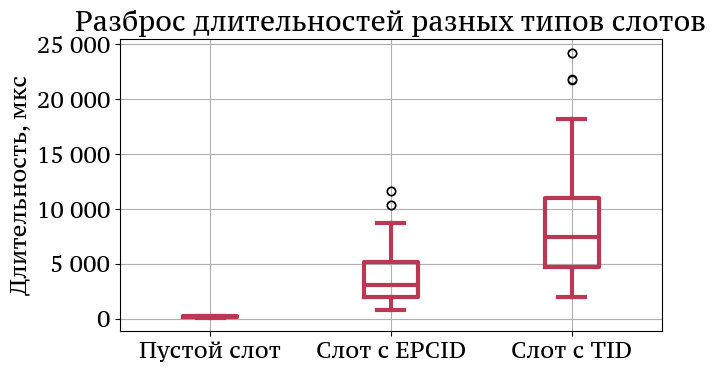

In [28]:
# При вычислении T1 делаем поправку на масштаб: времена в таблице
# записаны в микросекундах, частота BLF - в КГц. Результат вычислений
# мы будем хранить тоже в микросекундах.
DF["T1"] = DF.apply(lambda x: max_t1(x.RTcal, x.BLF/1_000), axis=1)
DF["T2"] = DF.apply(lambda x: max_t2(x.BLF/1_000), axis=1)
DF["T3"] = 0

def get_empty_slot(row: pd.DataFrame) -> float:
    return row["QueryRep"] + row["T1"] + row["T3"]

def get_reply_epcid_slot(row: pd.DataFrame) -> float:
    t = row["Query"] + 2 * (row["T1"] + row["T2"]) + \
        row["RN16"] + row["Ack"] + row["EPC+PC+CRC"]
    return t

def get_reply_tid_slot(row: pd.DataFrame) -> float:
    t = get_reply_epcid_slot(row) + 2 * (row["T1"] + row["T2"]) + \
        row["Req_RN"] + row["Handle"] + row["Read"] + row["Data"]
    return t

DF["EmptySlot"] = DF.apply(get_empty_slot, axis=1)
DF["EpcReplySlot"] = DF.apply(get_reply_epcid_slot, axis=1)
DF["TidReplySlot"] = DF.apply(get_reply_tid_slot, axis=1)

# Изобразим длительности слотов. Сохранять рисунок не будем.

def plot_slots():
    fig, ax = plt.subplots(figsize=(7, 4), nrows=1, ncols=1)
    props = {'linewidth': 3, 'color': get_color(0.5)}
    DF.boxplot(["EmptySlot", "EpcReplySlot", "TidReplySlot"], ax=ax,
               boxprops=props, whiskerprops=props, capprops=props, 
               meanprops=props, medianprops=props)
    ax.set_xticklabels(["Пустой слот", "Слот с EPCID", "Слот с TID"])
    ax.set_title("Разброс длительностей разных типов слотов")
    ax.set_ylabel("Длительность, мкс")
    set_axes_formatter(ax, use_y=True)
    plt.tight_layout()

plot_slots()

In [29]:
def get_max_round(row: pd.DataFrame, q: int, use_tid: bool = False) -> float:
    reply_slot_col = "EpcReplySlot" if not use_tid else "TidReplySlot"
    return row["EmptySlot"] * (2**q - 1) + row[reply_slot_col]

Рассчитаем максимальные длительности раундов для разных Tari и M.

Чтобы немного упростить вывод, не будем рассматривать все возможные комбинации 
`Tari`, `M`, `DR`, а выделим шесть разных наборов:

- `Tari = 6.25, M = 1, DR = 64/3` (самый быстрый)
- `Tari = 6.25, M = 4, DR = 64/3`
- `Tari = 12.5, M = 4, DR = 64/3`
- `Tari = 12.5, M = 4, DR = 8`
- `Tari = 25.0, M = 4, DR = 8`
- `Tari = 25.0, M = 8, DR = 8` (самый медленный)

In [30]:
ROUNDS_TARI_M_DR = [
    [6.25, TagEncoding.FM0, DR.DR_643],
    [6.25, TagEncoding.M4, DR.DR_643],
    [12.5, TagEncoding.M4, DR.DR_643],
    [12.5, TagEncoding.M4, DR.DR_8],
    [25.0, TagEncoding.M4, DR.DR_8],
    [25.0, TagEncoding.M8, DR.DR_8]
]
ROUNDS_MARKERS = ["o", "v", "^", "X", "<", ">"]
ROUNDS_COLORS = [get_color(i / len(ROUNDS_TARI_M_DR) * 0.8)
                 for i in range(len(ROUNDS_TARI_M_DR))]

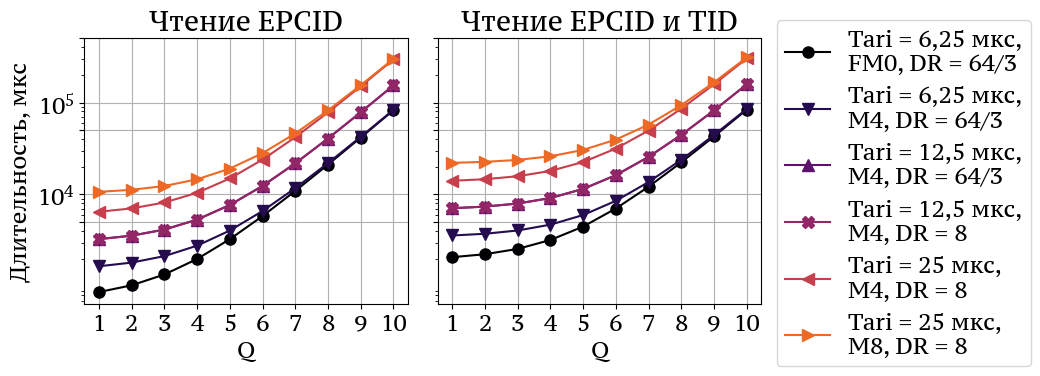

In [31]:
def plot_max_rounds(image_name: str = ""):
    fig, axes = plt.subplots(figsize=(8, 4), nrows=1, ncols=2, sharey=True)
    ax0, ax1 = axes
    
    ox = list(range(1, 11))
    df = DF[DF.TRext == False]
    
    for i, (tari, m, dr) in enumerate(ROUNDS_TARI_M_DR):    
        df_row = df[(df.Tari == tari) & (df.M == m) & (df.DR == dr)]
        
        oy_epc = [get_max_round(df_row, q, use_tid=False) for q in ox]
        oy_tid = [get_max_round(df_row, q, use_tid=True) for q in ox]

        c = ROUNDS_COLORS[i]
        marker = ROUNDS_MARKERS[i]
        label = f"Tari = {tari:n} мкс,\n{m.name}, DR = {str_dr(dr)}"
        
        ax0.plot(ox, oy_epc, marker=marker, markersize=8, color=c, label=label)
        ax1.plot(ox, oy_tid, marker=marker, markersize=8, color=c, label=label)

    for ax in axes:
        ax.grid()
        ax.set_yscale('log')
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.LogFormatterSciNotation())
        ax.get_yaxis().get_major_formatter().labelOnlyBase = False
        ax.set_yticks([5000, 10_000, 50_000, 100_000, 500_000])
        ax.set_xticks(ox)

    for ax in axes:
        ax.set_xlabel("Q")
    
    ax0.set_ylabel("Длительность, мкс")
    ax0.set_title(f"Чтение EPCID")
    ax1.set_title(f"Чтение EPCID и TID")
    
    fig.legend(*ax.get_legend_handles_labels(), loc='center right',
               bbox_to_anchor=(1.32, 0.48), ncol=1)

    plt.tight_layout()
    # savefig(image_name)

plot_max_rounds("ch2_round_durations")

## Определение максимального числа попыток передачи идентификатора метки

Зная скорость движения, можно вычислить максимальное число раундов, в которых
метка может передать свой идентификатор:

$$
N_r \approx \lfloor \frac{L}{\overline{T}_R v} \rfloor,
$$
где $L$ - длина пятна на дороге, на котором уровень сигнала достаточно высок,
$v$ - скорость движения, $\overline{T}_R$ - длительность раунда.

> Число раундов, в которых метка может участвовать, - больше, так как в раунды
с коллизией или ошибкой в каком-то из ответов (например, RN16), будут короче.
Подробней общее число раундов, с учетом битовых ошибок и коллизий, исследуется
в аналитической модели.

In [32]:
def get_num_rounds(row: pd.DataFrame, q: int, speed: float, length: float = L,
                   use_tid: bool = False) -> int:
    """
    Вычислить максимальную длительность раунда с единственной меткой.
    
    Args:
        row (pd.DataFrame): строка датафрейма DF
        q (int): величина Q
        speed (float): скорость в км/ч
        length (float): длина пятна дороги в метках
        use_tid (bool): используется ли TID
    
    Returns:
        num_rounds (int)
    """
    round_duration_us = get_max_round(row, q, use_tid)
    speed_m_us = kmph2mps(speed) / 1_000_000  # скорость в м/мкс
    return int(np.floor(length / (round_duration_us * speed_m_us)))

/var/folders/qy/yym87y9s4hz3mqqvbf36mk_r0000gn/T/ipykernel_70404/4201470109.py:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(np.floor(length / (round_duration_us * speed_m_us)))


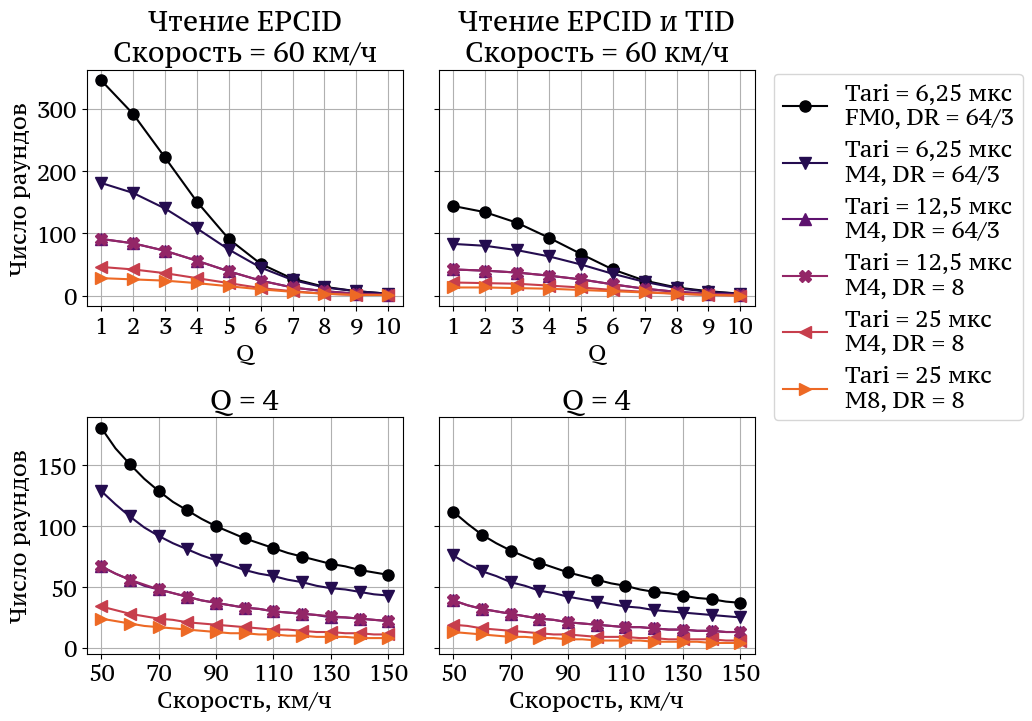

In [34]:
def plot_num_rounds(image_name: str = ""):
    fig, axes = plt.subplots(figsize=(8, 7.5), nrows=2, ncols=2, sharey='row')
    (ax0, ax1), (ax2, ax3) = axes
    
    ov = np.linspace(50, 150, 21)
    oq = np.arange(1, 11)
    df = DF[DF.TRext == False]
    
    # Определим вспомогательную функцию, которрая вычисляет длительности
    # раундов и изображает их на осях для заданных значений Tari, M, DR
    def plot(inp_index: int, ax_left, ax_right, what_fixed: str):
        tari, m, dr = ROUNDS_TARI_M_DR[inp_index]
        marker = ROUNDS_MARKERS[inp_index]
        color = ROUNDS_COLORS[inp_index]

        df_row = df[(df.Tari == tari) & (df.M == m) & (df.DR == dr)]
        what_fixed = what_fixed.upper()
        
        if what_fixed == "Q":
            ox = ov
            markevery = 2
            oy_epc = [get_num_rounds(df_row, Q, v, use_tid=False) for v in ox]
            oy_tid = [get_num_rounds(df_row, Q, v, use_tid=True) for v in ox]
        elif what_fixed in ["SPEED", "V"]:
            ox = oq
            markevery = 1
            oy_epc = [get_num_rounds(df_row, q, V, use_tid=False) for q in ox]
            oy_tid = [get_num_rounds(df_row, q, V, use_tid=True) for q in ox]
        else:
            raise ValueError("what_fixed should be Q or V")
        
        props = {
            "color": ROUNDS_COLORS[inp_index],
            "marker": ROUNDS_MARKERS[inp_index],
            "markersize": 8,
            "markevery": markevery,
            "label": f"Tari = {tari:n} мкс\n{m.name}, DR = {str_dr(dr)}",
        }
        
        ax_left.plot(ox, oy_epc, **props)
        ax_right.plot(ox, oy_tid, **props)
    
    # ---- конец определения вспомогательной функции -----
    
    for i, _ in enumerate(ROUNDS_TARI_M_DR):    
        plot(i, ax0, ax1, "V")
        plot(i, ax2, ax3, "Q")

    for ax in (ax0, ax1, ax2, ax3):
        ax.grid()
    for ax in (ax0, ax1):
        ax.set_xlabel("Q")
        ax.set_xticks(oq)
    for ax in (ax2, ax3):
        ax.set_xlabel("Скорость, км/ч")
        ax.set_title(f"Q = {Q}")
        ax.set_xticks((50, 70, 90, 110, 130, 150))
    for ax in (ax0, ax2):
        ax.set_ylabel("Число раундов")
    
    ax0.set_title(f"Чтение EPCID\nСкорость = {V} км/ч")
    ax1.set_title(f"Чтение EPCID и TID\nСкорость = {V} км/ч")
    ax2.set_title(f"Q = {Q}")
    
    
    fig.legend(*ax.get_legend_handles_labels(), loc='center right',
               bbox_to_anchor=(1.31, 0.651), ncol=1)

    plt.tight_layout()
    # savefig(image_name)

plot_num_rounds("ch2_max_num_rounds")